In [1]:
import os
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal, linalg, stats
from sklearn.metrics import pairwise

from plasma_data_handler import PlasmaDataHandler

In [2]:
instrument = 'BES'
channel = 4
labeled_keys = ['00470', '00480', '00492']

raw_data_file = '/gpfs/slac/staas/fs1/g/coffee_group/edgeml_fes_data/ecebes/166578BES'
labeled_data_file = '/sdf/home/f/foshea/Plasma/labeled-elm-events.hdf5'

t = PlasmaDataHandler('shot_166578.h5')
h = PlasmaDataHandler('shot_180625.h5')

In [3]:
ch_str = 'besfu{:>02}'.format(channel)
raw_file = np.load(raw_data_file, allow_pickle=True)
raw_data = raw_file[ch_str]['data.BES']
raw_time = raw_file[ch_str]['data.time']
del raw_file

labeled_data = {}
with h5py.File(labeled_data_file, 'r') as hdf:
    for key in labeled_keys:
        u = {}
        for k, v in hdf[key].items():
            if k == 'signals':
                u[k] = v[channel - 1, :]
            else:
                u[k] = v[()]
        labeled_data[key] = u
        
spectrogram = t.createSpectrogram('BES', 4, 1024, False)

Text(0, 0.5, 'volts')

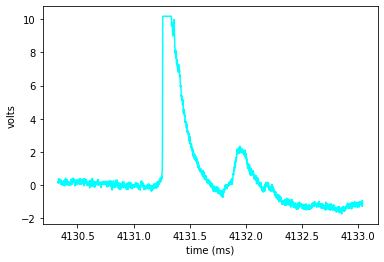

In [4]:
plt.plot(labeled_data['00480']['time'], labeled_data['00480']['signals'], color='cyan')
plt.xlabel('time (ms)')
plt.ylabel('volts')

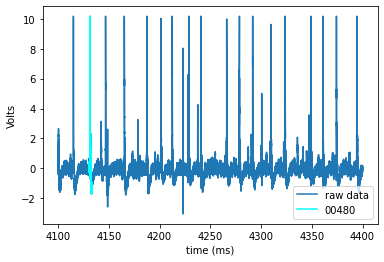

In [5]:
limits = [3500000, 3800000]
times = raw_time[limits[0]:limits[1]]
signal = raw_data[limits[0]:limits[1]]
plt.plot(times, signal, label='raw data')
# for k, v in labeled_data.items():
#     plt.plot(v['time'], v['signals'], label=k)
plt.plot(labeled_data['00480']['time'], labeled_data['00480']['signals'], color='cyan', label='00480')
plt.legend(loc='lower right')
plt.xlabel('time (ms)')
plt.ylabel('Volts')
plt.show()

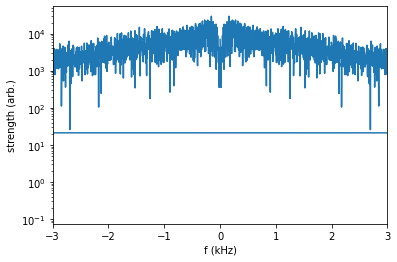

In [6]:
freqs = np.fft.fftfreq(limits[1] - limits[0], d=1e-6 * 1e3)
raw_fft = np.fft.fft(signal)
plt.semilogy(freqs, np.abs(raw_fft))
plt.xlim([-3, 3])

plt.xlabel('f (kHz)')
plt.ylabel('strength (arb.)')
plt.show()

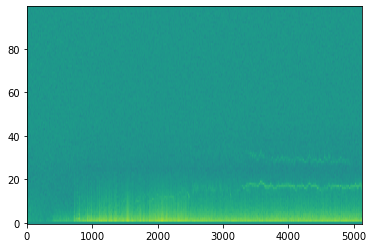

In [7]:
plt.imshow(spectrogram[:100, :], origin='lower', aspect='auto')

# Plot a channel from all the raw BES data I have

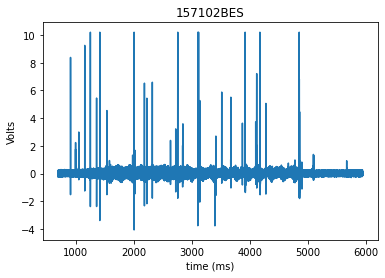

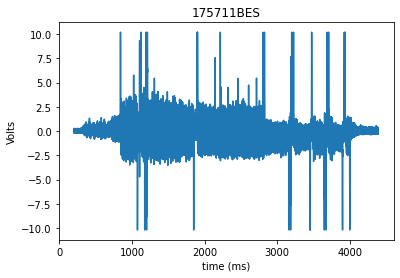

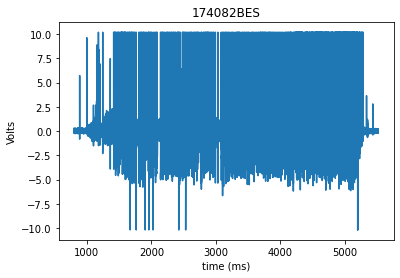

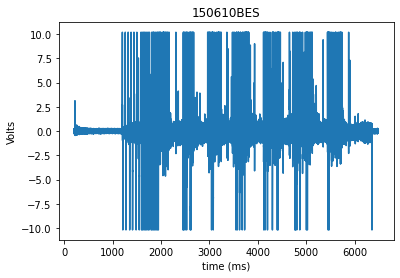

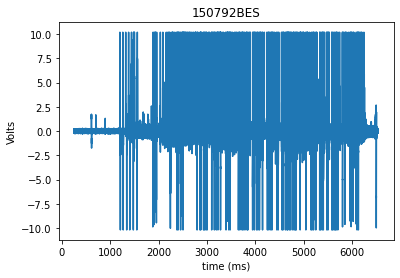

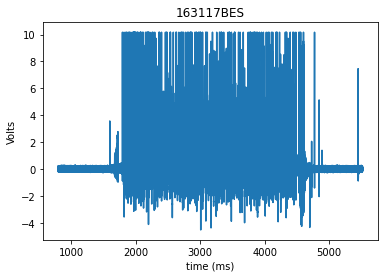

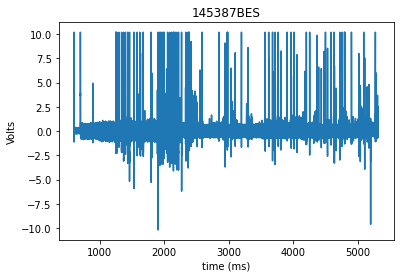

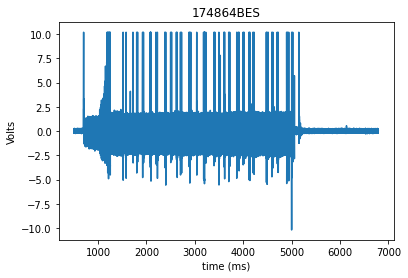

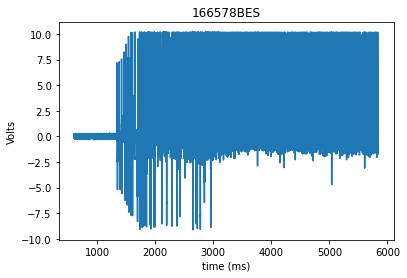

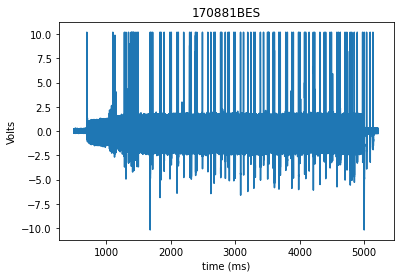

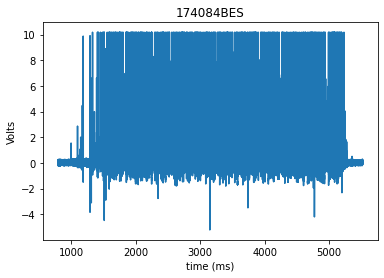

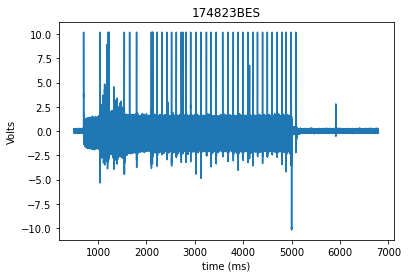

In [ ]:
ch_str = 'besfu{:>02}'.format(channel)
raw_path = '/gpfs/slac/staas/fs1/g/coffee_group/edgeml_fes_data/ecebes'
for f in os.listdir(raw_path):
    if 'BES' in f:
        full_name = '/'.join([raw_path, f])
        pointer = np.load(full_name, allow_pickle=True)
        s = pointer[ch_str]['data.BES']
        ts = pointer[ch_str]['data.time']
        del pointer
        plt.plot(ts, s)
        plt.title(f)
        plt.xlabel('time (ms)')
        plt.ylabel('Volts')
        plt.show()
        time.sleep(5)

## Do some statistics on shot 166578

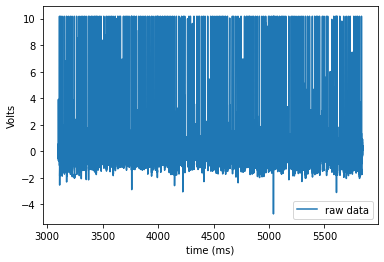

In [6]:
limits = [2500000, -1]
times = raw_time[limits[0]:limits[1]]
signal = raw_data[limits[0]:limits[1]]
plt.plot(times, signal, label='raw data')

plt.legend(loc='lower right')
plt.xlabel('time (ms)')
plt.ylabel('Volts')
plt.show()

In [66]:
saturations = signal >= 10.0
previous = True
starts = []
for idx, point in enumerate(saturations[20:], 20):
    if point and not previous:
        starts.append(idx)
    previous = saturations[idx - 20:idx+1].any()

indicator = np.zeros_like(signal)
indicator[starts] = 1

In [155]:
lam = len(starts) / (times[-1] - times[0])

def poisson(b, k):
    return b ** k * np.exp(-1 * b) / np.math.factorial(k)

def counter(ind, length):
    counts = []
    start = 0
    end = length
    while end < len(ind):
        counts.append(int(ind[start:end].sum()))
        start = end
        end += length
    return counts
    
def plot_stats(ind, length, lam, times, k_max=7):
    dt = times[length] - times[0]
    avg = lam * dt
    ks = np.linspace(0, k_max, k_max+1, endpoint=True, dtype=int)
    
    the_counts = counter(ind, length)
    the_bins = np.linspace(-0.5, k_max + 0.5, k_max + 2, endpoint=True)
    n, edges = np.histogram(the_counts, bins=the_bins, density=True)
    plt.bar(ks - 0.5, n, width=0.5, color='b', align='edge', label='BES')

    pois = [poisson(avg, k) for k in ks]
    plt.bar(ks, pois, width=0.5, color='r', align='edge', label='Poisson')
    
    plt.legend(loc='upper right')
    plt.show()

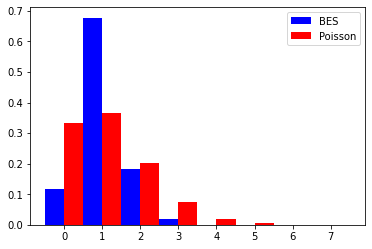

In [156]:
plot_stats(indicator, 18000, lam, times)